In [1]:
import getpass


tess_data_dir = f'/home/{getpass.getuser()}/lc'
tces_file = 'astronet/tces-new+old.csv'

tic = 349992455

1087


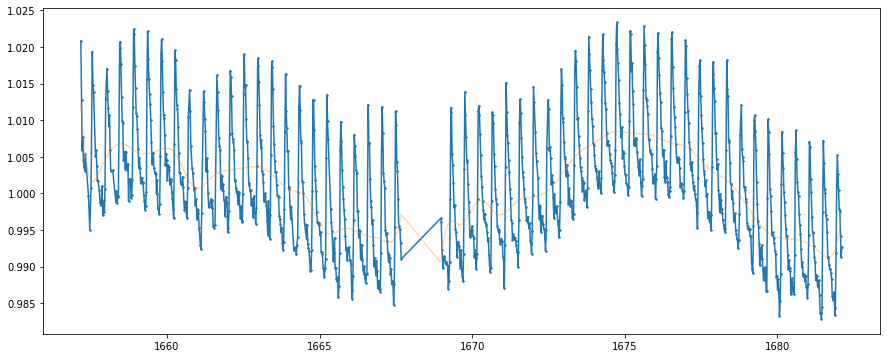

In [2]:
from matplotlib import pyplot as plt
from light_curve_util import tess_io
from light_curve_util import keplersplinev2


file_names = tess_io.tess_filenames(tic, tess_data_dir)
all_time, all_mag = tess_io.read_tess_light_curve(file_names, 'SAP_FLUX')
fig = plt.figure(figsize=(15, 6))
plt.plot(all_time, all_mag, '.-', markersize=3)

filtered_mag, metadata = keplersplinev2.choosekeplersplinev2(all_time, all_mag, return_metadata=True)
plt.plot(all_time, filtered_mag, '-', alpha=0.3)

print(len(filtered_mag))

_ = _

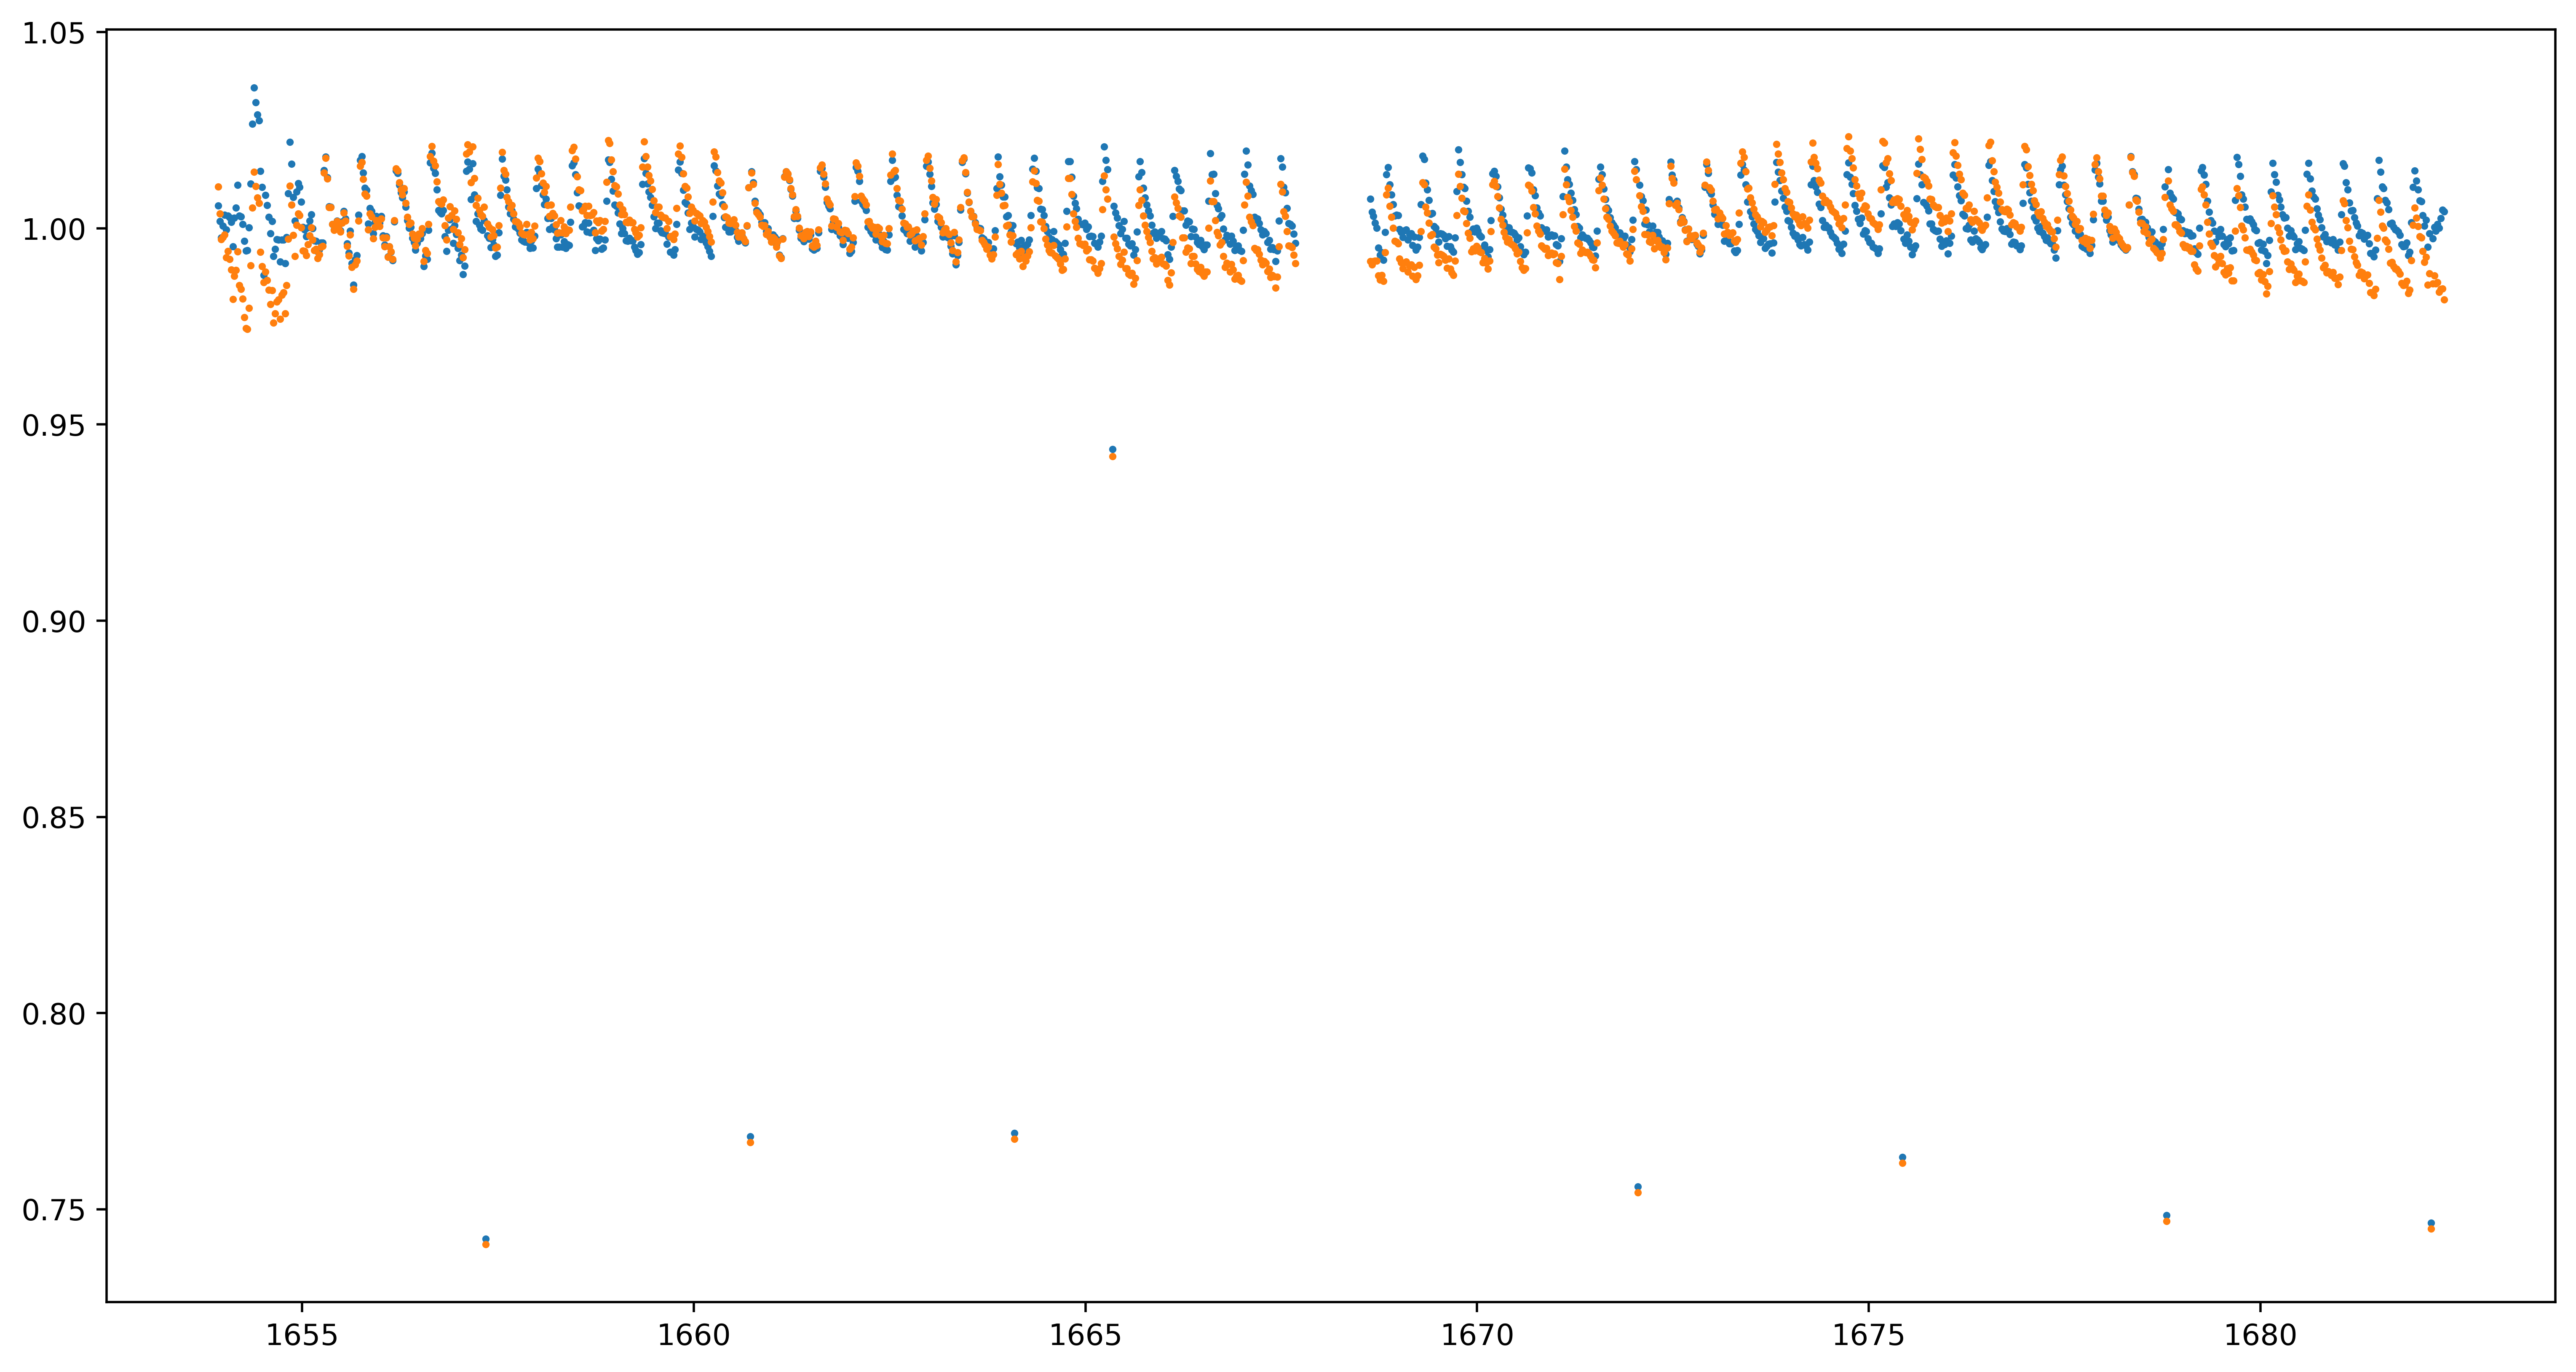

In [3]:
from astropy.io import fits


file_names = tess_io.tess_filenames(tic, tess_data_dir)
f = fits.open(file_names)

td = f[1].data["TIME"]
fd = f[1].data["KSPSAP_FLUX"]

fig = plt.figure(figsize=(15, 8), dpi=500)
plt.plot(td, fd, '.', markersize=3)
plt.plot(td, f[1].data["SAP_FLUX"], '.', markersize=3)
_ = _

In [4]:
import pandas as pd


tce_table = pd.read_csv(tces_file, header=0)
tce_table.Duration = tce_table.Duration / 24.0
tce_table = tce_table.drop(columns=['Disposition'])
tce = tce_table[tce_table.tic_id == tic]
period = tce.Period.values.item()
epoc = tce.Epoc.values.item()
duration = tce.Duration.values.item()

In [5]:
import numpy as np
from light_curve_util import util


def get_spline_mask(time, period, t0, tdur):
    phase = util.phase_fold_time(time, period, t0)
    outtran = (np.abs(phase) > (tdur / 24.0))
    return outtran

def filter_outliers(time, flux):
  valid = ~np.isnan(flux)
  time, flux = time[valid], flux[valid]
  inliers =  flux < (flux.mean() + 7 * flux.std())
  return time[inliers], flux[inliers]


ValueError: min() arg is an empty sequence

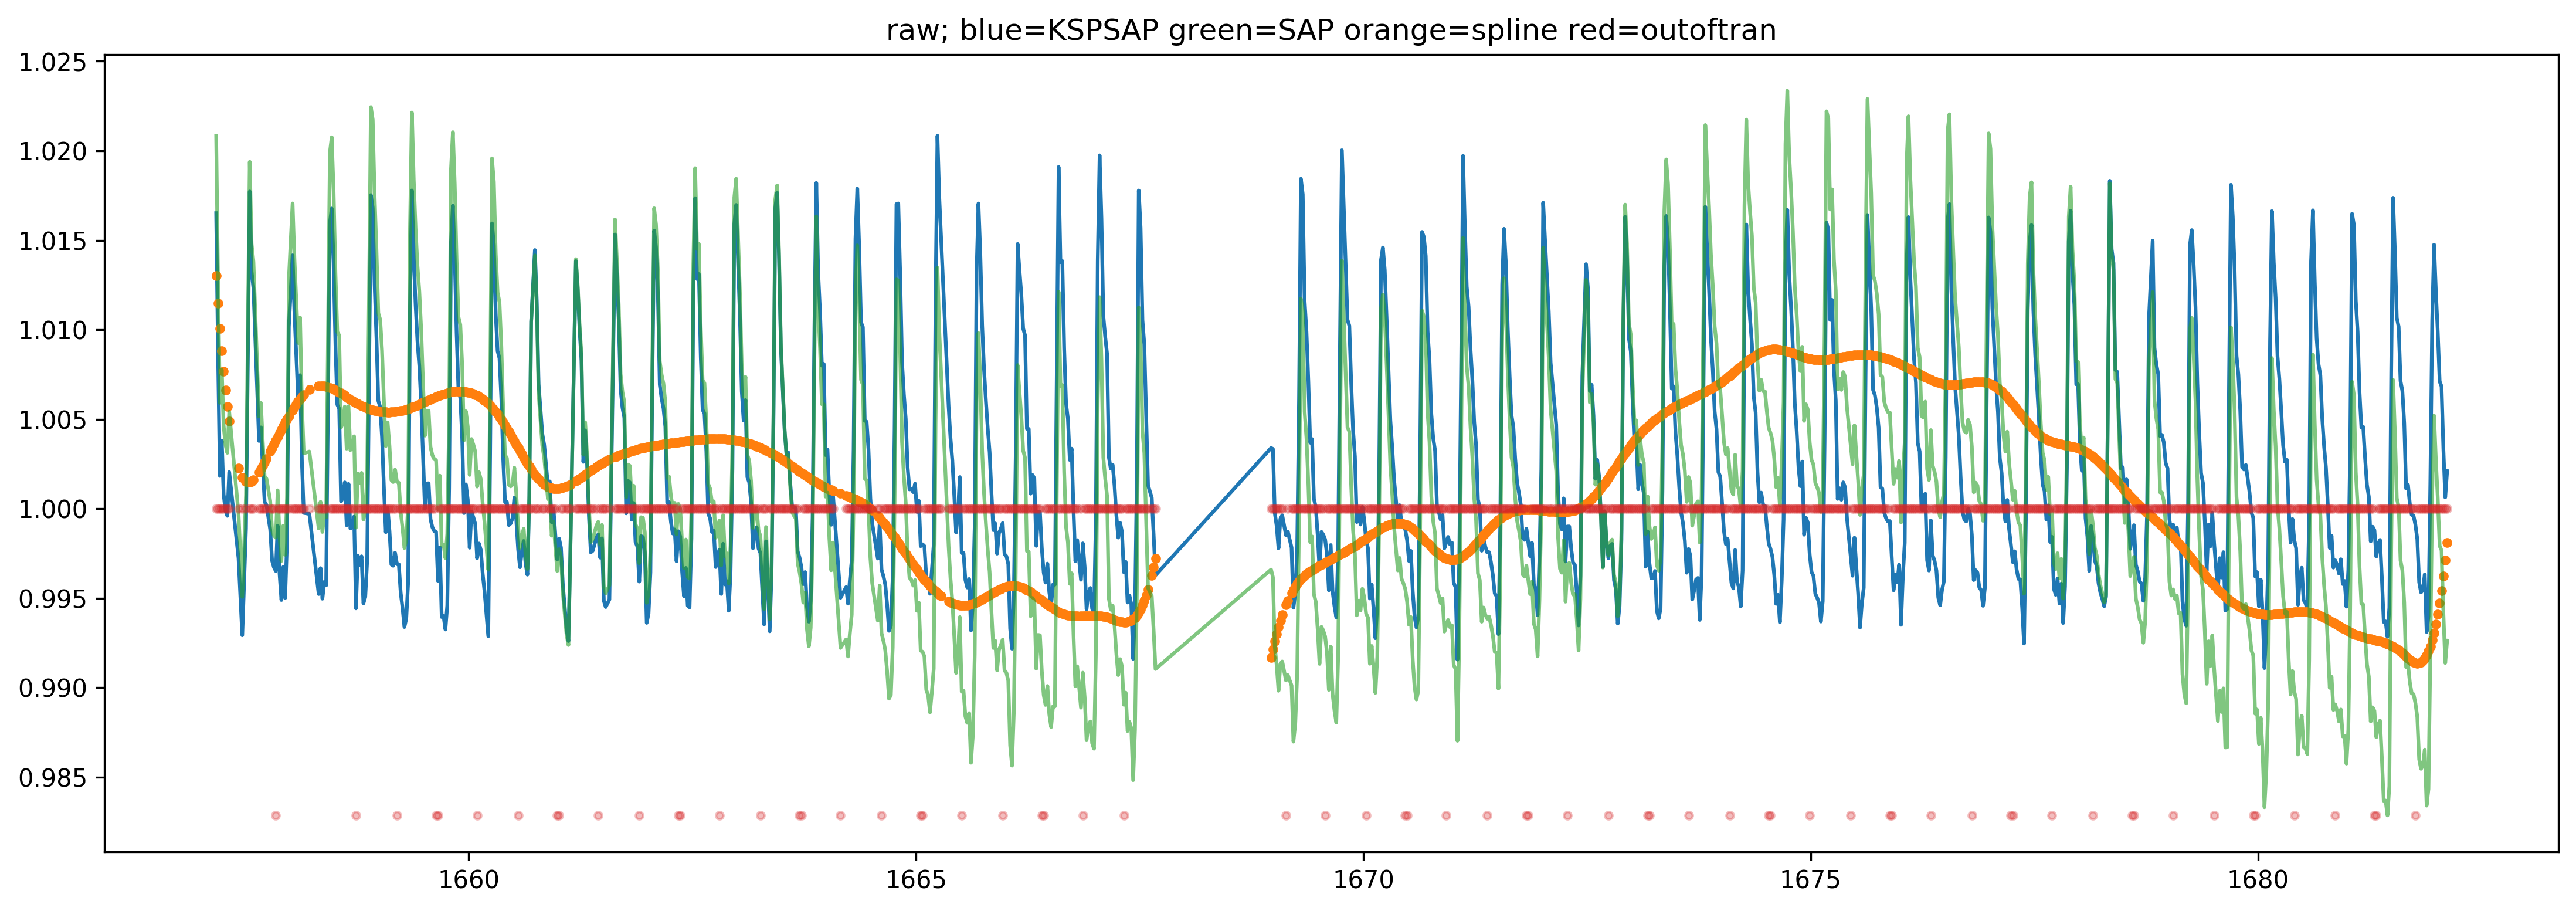

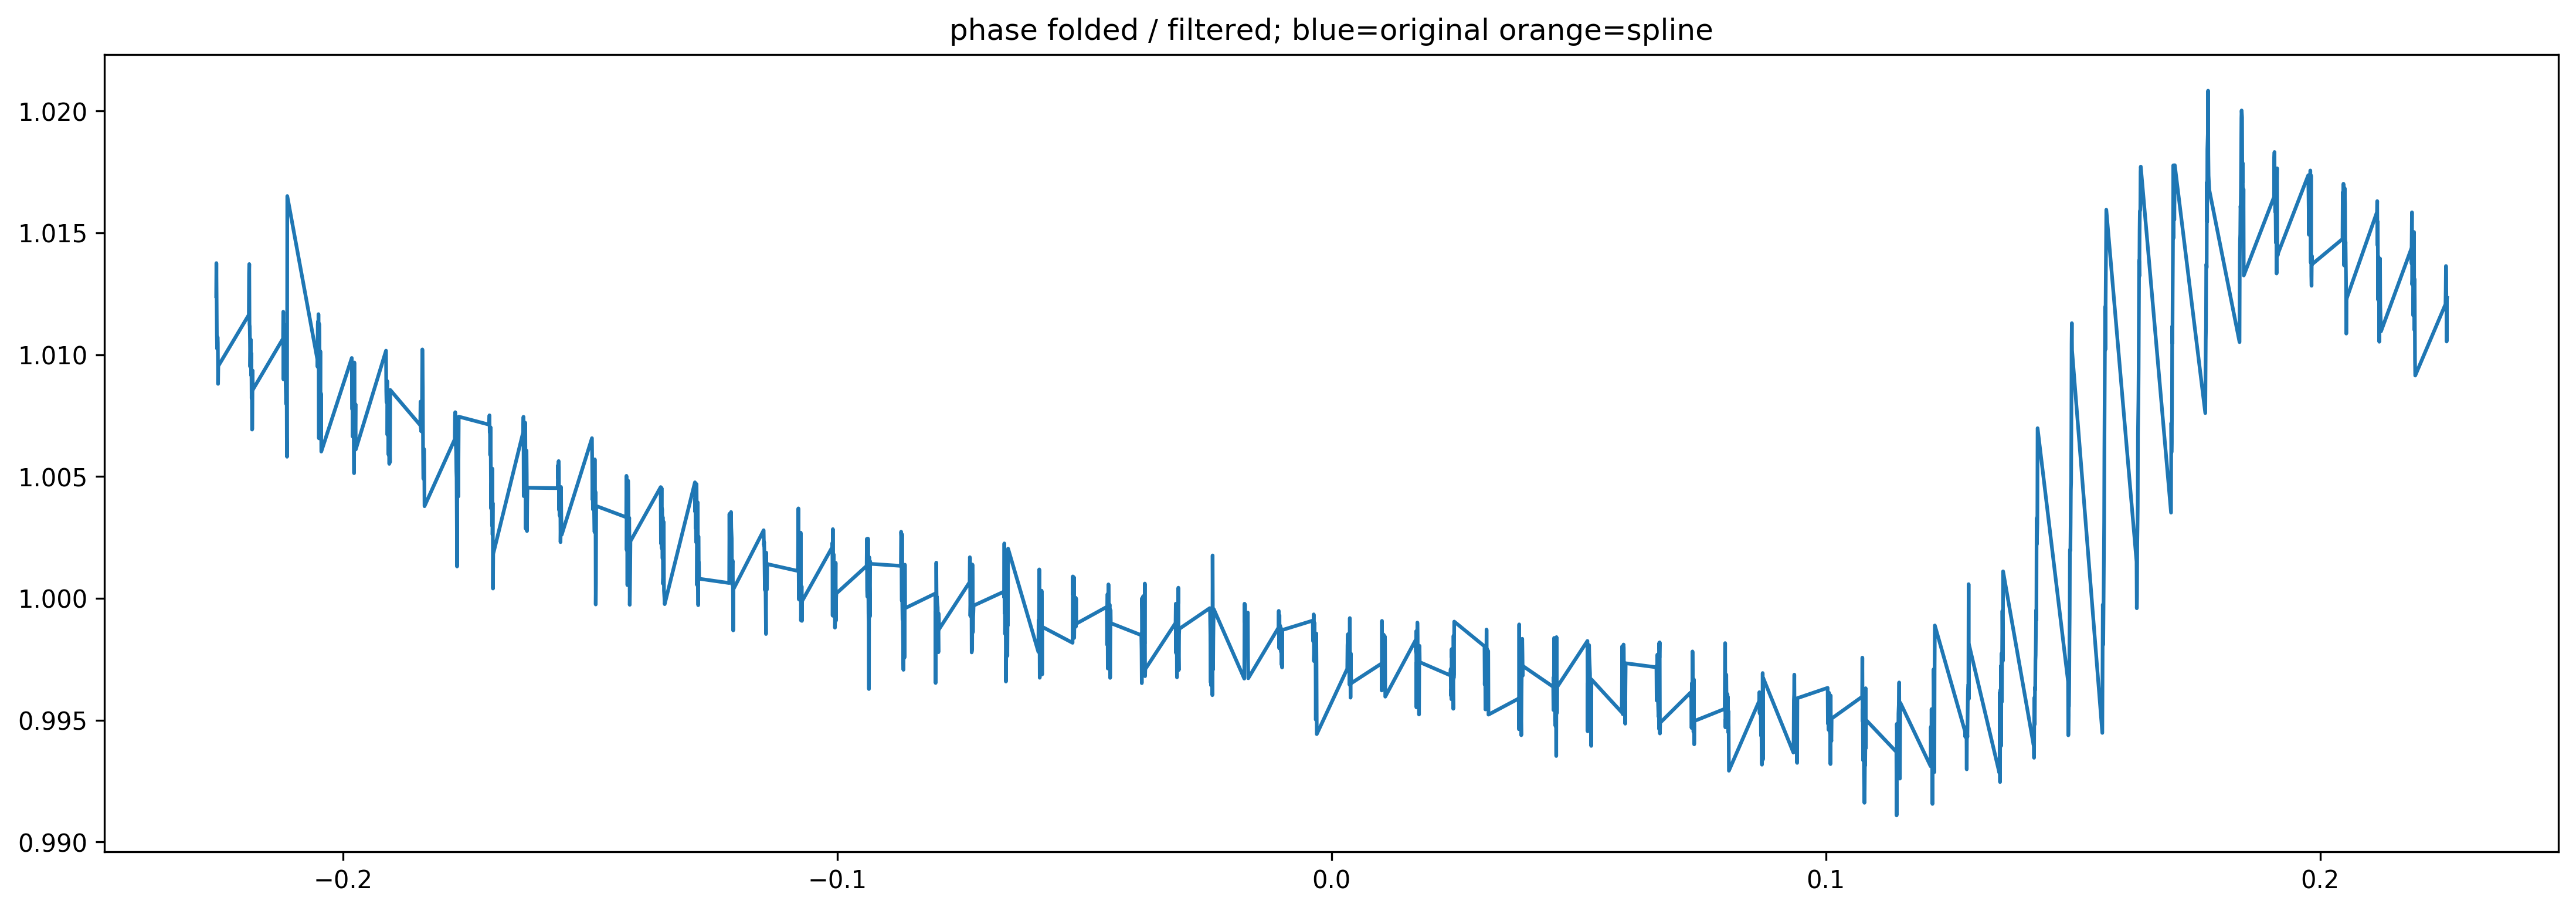

In [6]:
from matplotlib import pyplot as plt
from astronet.data import preprocess

t, f = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'KSPSAP_FLUX')
ut, uf = preprocess.read_and_process_light_curve(tic, tess_data_dir, 'SAP_FLUX')
input_mask = get_spline_mask(ut, period, epoc, duration)
sf = keplersplinev2.choosekeplersplinev2(ut, uf, input_mask=input_mask)

fig = plt.figure(figsize=(18, 6), dpi=300)
plt.plot(t, f, '-', markersize=3)
plt.plot(ut, sf, 'o', markersize=3)
plt.plot(ut, uf, '-', markersize=3, alpha=0.6)
mask_plot = np.where(input_mask, 1.0, min(np.min(f), np.min(sf), np.min(uf)))
plt.plot(ut, mask_plot, '.', alpha=0.3)
plt.title('raw; blue=KSPSAP green=SAP orange=spline red=outoftran')

ft, ff = preprocess.phase_fold_and_sort_light_curve(t, f, period, epoc)
_, fm = preprocess.phase_fold_and_sort_light_curve(t, input_mask, period, epoc)

ut, nf = preprocess.detrend_and_filter(tic, ut, uf, period, epoc, duration)
sft, sff = preprocess.phase_fold_and_sort_light_curve(ut, nf, period, epoc)

fig = plt.figure(figsize=(18, 6), dpi=300)
plt.plot(ft, ff, '-', markersize=3)
plt.plot(sft, sff, '-o', markersize=3, alpha=0.6)
# plt.plot(sft, np.where(fm, 1, min(sff)), '-o', markersize=3, alpha=0.6)
plt.title('phase folded / filtered; blue=original orange=spline')

gv = preprocess.global_view(ft, ff, period)
sgv = preprocess.global_view(sft, sff, period)

fig = plt.figure(figsize=(18, 6), dpi=300)
plt.plot(gv, '-', markersize=3)
plt.plot(sgv, 'o-', markersize=3)
plt.title('global view; blue=original orange=spline')

lv = preprocess.local_view(ft, ff, period, duration)
lvs = preprocess.local_view(sft, sff, period, duration)

fig = plt.figure(figsize=(18, 6), dpi=300)
plt.plot(lv, '-', markersize=3)
plt.plot(lvs, 'o-', markersize=3)
plt.title('local view; blue=original orange=spline')


lv = preprocess.secondary_view(ft, ff, period, duration)
lvs = preprocess.secondary_view(sft, sff, period, duration)

fig = plt.figure(figsize=(18, 6), dpi=300)
plt.plot(lv, '-', markersize=3)
plt.plot(lvs, 'o-', markersize=3)
plt.title('secondary view; blue=original orange=spline')
_ = _

In [ ]:
from astronet.data import generate_input_records


generate_input_records.FLAGS = generate_input_records.parser.parse_args([
  '--tess_data_dir', '/home/mdan/lc',
  '--output_dir', '/dev/null',
  '--input_tce_csv_file', tces_file,
])


ex = generate_input_records._process_tce(list(tce.iterrows())[0][1], True)

plt.plot(ex.features.feature['global_view'].float_list.value)
plt.show()
plt.plot(ex.features.feature['local_view'].float_list.value)
plt.show()
plt.plot(ex.features.feature['secondary_view'].float_list.value)
plt.show()